# Lecture 06 - Panel Data models



In [ ]:
#%pip install linearmodels

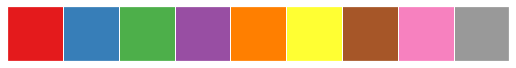

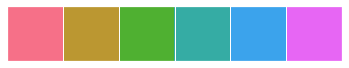

In [1]:
import numpy as np

import pandas as pd
#pd.set_option('display.max_columns', 30)                    # Display 30 columns for viewing purposes
#pd.options.display.float_format = '{:,.2f}'.format         # Reduce decimal points to 2

import datetime as dt
#import pandas_datareader.data as web

import statsmodels
# we will use `smf` and `sm` to constract and estimate same regressions but using different ways
import statsmodels.formula.api as smf  
import statsmodels.api as sm
import statsmodels.stats.api as sms
from patsy import dmatrices
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

from linearmodels import PanelOLS, RandomEffects


from matplotlib import pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set_style('darkgrid')
sns.palplot(sns.color_palette("Set1"))
sns.palplot(sns.color_palette("husl"))
plt.rc("figure", figsize=(15, 10))
plt.rc("savefig", dpi=90)
plt.rc("font",family="sans-serif")
plt.rc("font",size=14)

## Panel Data structure

The most precise data format to use is a MultiIndex DataFrame. Here `set_index` is used to set the MultiIndex using the respondent's number (entity) and year (time). 

In [2]:
from linearmodels.datasets import wage_panel
data = wage_panel.load()
data

,nr,year,black,exper,hisp,hours,married,educ,union,lwage,expersq,occupation
0,13,1980,0,1,0,2672,0,14,0,1.197540,1,9
1,13,1981,0,2,0,2320,0,14,1,1.853060,4,9
2,13,1982,0,3,0,2940,0,14,0,1.344462,9,9
3,13,1983,0,4,0,2960,0,14,0,1.433213,16,9
4,13,1984,0,5,0,3071,0,14,0,1.568125,25,5
...,...,...,...,...,...,...,...,...,...,...,...,...
4355,12548,1983,0,8,0,2080,1,9,0,1.591879,64,5
4356,12548,1984,0,9,0,2080,1,9,1,1.212543,81,5
4357,12548,1985,0,10,0,2080,1,9,0,1.765962,100,5
4358,12548,1986,0,11,0,2080,1,9,1,1.745894,121,5


In [3]:
print(wage_panel.DESCR)


F. Vella and M. Verbeek (1998), "Whose Wages Do Unions Raise? A Dynamic Model
of Unionism and Wage Rate Determination for Young Men," Journal of Applied
Econometrics 13, 163-183.

nr                       person identifier
year                     1980 to 1987
black                    =1 if black
exper                    labor market experience
hisp                     =1 if Hispanic
hours                    annual hours worked
married                  =1 if married
educ                     years of schooling
union                    =1 if in union
lwage                    log(wage)
expersq                  exper^2
occupation               Occupation code



In [4]:
year = pd.Categorical(data.year)
year

[1980, 1981, 1982, 1983, 1984, ..., 1983, 1984, 1985, 1986, 1987]
Length: 4360
Categories (8, int64): [1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987]

In [5]:
# Panel data structure suggests repeated observations on the same entity over some period of time. 
# Thus, each observation is usually denoted with a set of indices (often time and item/id)

data = data.set_index(['nr', 'year']) # note dual indexing by identifier and time
data

black  exper  hisp  hours  married  educ  union     lwage  \
nr    year                                                              
13    1980      0      1     0   2672        0    14      0  1.197540   
      1981      0      2     0   2320        0    14      1  1.853060   
      1982      0      3     0   2940        0    14      0  1.344462   
      1983      0      4     0   2960        0    14      0  1.433213   
      1984      0      5     0   3071        0    14      0  1.568125   
...           ...    ...   ...    ...      ...   ...    ...       ...   
12548 1983      0      8     0   2080        1     9      0  1.591879   
      1984      0      9     0   2080        1     9      1  1.212543   
      1985      0     10     0   2080        1     9      0  1.765962   
      1986      0     11     0   2080        1     9      1  1.745894   
      1987      0     12     0   3380        1     9      1  1.466543   

            expersq  occupation  
nr    year                       
13    1980        1           9  
      1981        4           9  
      1982        9           9  
      1983       16           9  
      1984       25           5  
...             ...         ...  
12548 1983       64           5  
      1984       81           5  
      1985      100           5  
      1986      121           5  
      1987      144           5  

[4360 rows x 10 columns]

In [6]:
data['year'] = year
data

black  exper  hisp  hours  married  educ  union     lwage  \
nr    year                                                              
13    1980      0      1     0   2672        0    14      0  1.197540   
      1981      0      2     0   2320        0    14      1  1.853060   
      1982      0      3     0   2940        0    14      0  1.344462   
      1983      0      4     0   2960        0    14      0  1.433213   
      1984      0      5     0   3071        0    14      0  1.568125   
...           ...    ...   ...    ...      ...   ...    ...       ...   
12548 1983      0      8     0   2080        1     9      0  1.591879   
      1984      0      9     0   2080        1     9      1  1.212543   
      1985      0     10     0   2080        1     9      0  1.765962   
      1986      0     11     0   2080        1     9      1  1.745894   
      1987      0     12     0   3380        1     9      1  1.466543   

            expersq  occupation  year  
nr    year                             
13    1980        1           9  1980  
      1981        4           9  1981  
      1982        9           9  1982  
      1983       16           9  1983  
      1984       25           5  1984  
...             ...         ...   ...  
12548 1983       64           5  1983  
      1984       81           5  1984  
      1985      100           5  1985  
      1986      121           5  1986  
      1987      144           5  1987  

[4360 rows x 11 columns]

## Generate grouped data

### Try a few simple tasks first

In [7]:
# Geneate 2 columns of length 10 of random normal observations
np.random.randn(10,2)

array([[ 0.1882558 , -0.98694551],
       [-0.24723444, -1.530349  ],
       [ 0.16362071, -0.35479927],
       [ 1.43928513,  1.97155147],
       [ 0.19095298,  0.0116749 ],
       [-0.30846906,  0.31003431],
       [ 0.47982666,  1.97674176],
       [-0.94912563, -0.18460234],
       [ 0.78604895, -1.03656139],
       [ 2.11241671,  0.21252204]])

In [8]:
# Replicate a set of constants - say you have 2-by-1 array of numbers (one row of two columns) and you want to 
# create 10 rows with the same number of columns
constants=[10, 20]
np.tile(constants,(10,1))

array([[10, 20],
       [10, 20],
       [10, 20],
       [10, 20],
       [10, 20],
       [10, 20],
       [10, 20],
       [10, 20],
       [10, 20],
       [10, 20]])

In [9]:
# You can add the two together
np.random.randn(10,2)+np.tile(constants,(10,1))

array([[10.72947042, 19.66201365],
       [ 9.59589024, 18.99803949],
       [11.23333121, 19.09616959],
       [10.0442512 , 20.77885984],
       [ 9.51400988, 20.32648546],
       [10.52509076, 18.53482016],
       [10.56488004, 21.57597828],
       [ 9.33463378, 22.19739765],
       [ 9.54195207, 20.68966134],
       [10.60653801, 21.50784196]])

### Lets simulate the panel data 

In [11]:
# Set up parametrs for simulated panel structure
N=200                            # number of observations per group
G=4                              # number of groups
a=[10, 100, 150, 260]            # list of intercepts for each group
beta=-4;                         # slope of the linear relation (same for all groups)
shift_in_x=[10, 20, 30, 40]      # values of X around which the simulated data will be populated

x=np.random.randn(N,G)+np.tile(shift_in_x,(N,1)) # see above  
e=np.random.randn(N,G)*4                         # generate some noise (you can control the size of noise)
c=np.tile([1,2,3,4],(N,1))                       # group identifiers (used for colouring the plot)
y=np.tile(a,(N,1))+beta*x+e       # e.g. Y=a+b*X+e only here Y and X are matrices (tables), not vectors.

# Reshape matrix data to column vectors
Y=y.flatten()
X=x.flatten()
C=c.flatten()

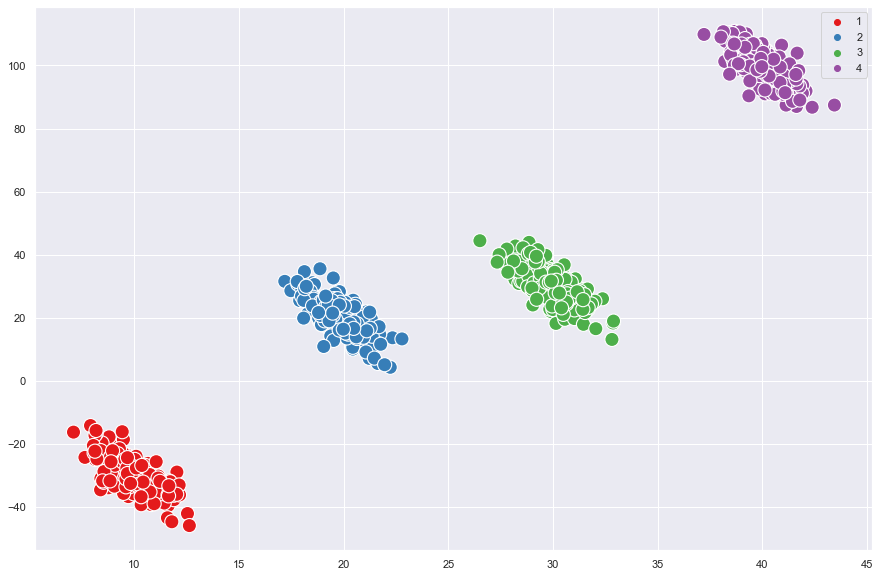

In [12]:
fig, ax = plt.subplots(figsize=(15,10))
sns.scatterplot(x=X,y=Y,hue=C,s=200,palette="Set1")
plt.show()

In [13]:
data={'Y':Y,'X':X,'C':C}
df=pd.DataFrame(data, columns=['Y', 'X', 'C'])
df

,Y,X,C
0,-35.429745,10.706751,1
1,23.087122,19.344710,2
2,24.734449,29.894506,3
3,93.641602,39.903549,4
4,-36.753887,9.723789,1
...,...,...,...
795,102.229823,39.924131,4
796,-32.571467,9.832697,1
797,21.625390,18.804499,2
798,39.490574,29.205341,3


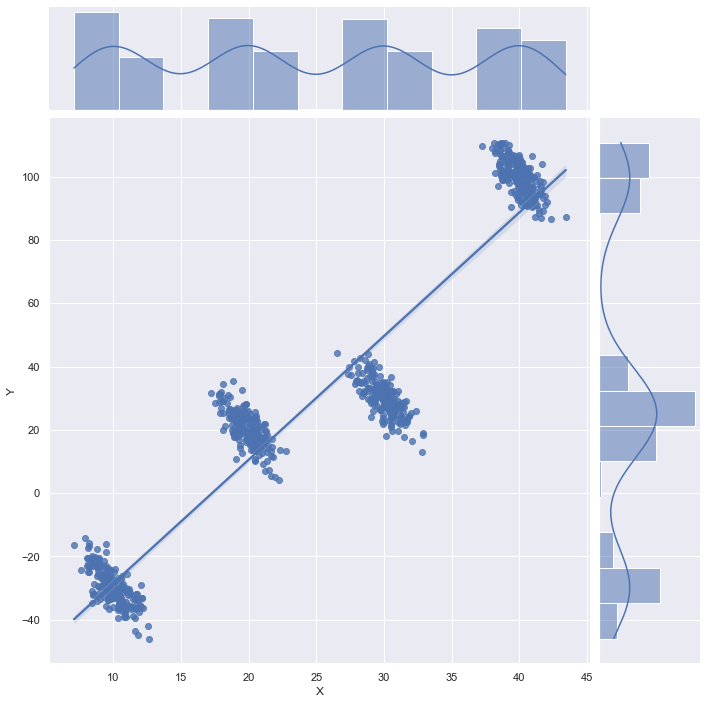

In [14]:
sns.jointplot(x="X", y="Y", data=df,
           kind="reg", height=10, space=0.08)
plt.show()

## Fit OLS model

In [15]:
reg1 = smf.ols('Y ~ X', data=df).fit()
reg1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.894
Method:                 Least Squares   F-statistic:                     6740.
Date:                Sat, 26 Feb 2022   Prob (F-statistic):               0.00
Time:                        22:41:09   Log-Likelihood:                -3308.5
No. Observations:                 800   AIC:                             6621.
Df Residuals:                     798   BIC:                             6630.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -67.6204      1.304    -51.860      0.000     -70.180     -65.061
X              3.9082      0.048     82.096      0.000       3.815       4.002
==============================================================================
Omnibus:                       30.407   Durbin-Watson:                   2.916
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               26.955
Skew:                          -0.386   Prob(JB):                     1.40e-06
Kurtosis:                       2.539   Cond. No.                         66.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [16]:
# Currently our data looks like this:
df

,Y,X,C
0,-35.429745,10.706751,1
1,23.087122,19.344710,2
2,24.734449,29.894506,3
3,93.641602,39.903549,4
4,-36.753887,9.723789,1
...,...,...,...
795,102.229823,39.924131,4
796,-32.571467,9.832697,1
797,21.625390,18.804499,2
798,39.490574,29.205341,3


In [17]:
# To be able to use panel data structure, we need to convert our data to allow multi indexing
df=pd.DataFrame(data, columns=['Y', 'X', 'C'])

c = pd.Categorical(df.C) # convert groups column to categorical variable
df['idx'] = df.index
df = df.set_index(['C','idx'])
df

,,Y,X
C,idx,,
1,0,-35.429745,10.706751
2,1,23.087122,19.344710
3,2,24.734449,29.894506
4,3,93.641602,39.903549
1,4,-36.753887,9.723789
...,...,...,...
4,795,102.229823,39.924131
1,796,-32.571467,9.832697
2,797,21.625390,18.804499


In [18]:
# Pooled regression = same as OLS
reg = PanelOLS.from_formula('Y ~ 1+ X',df)
res = reg.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                      Y   R-squared:                        0.8941
Estimator:                   PanelOLS   R-squared (Between):              0.9309
No. Observations:                 800   R-squared (Within):              -1.5714
Date:                Sat, Feb 26 2022   R-squared (Overall):              0.8941
Time:                        22:42:37   Log-likelihood                   -3308.5
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      6739.7
Entities:                           4   P-value                           0.0000
Avg Obs:                       200.00   Distribution:                   F(1,798)
Min Obs:                       200.00                                           
Max Obs:                       200.00   F-statistic (robust):             6739.7
                            

In [19]:
# Fixed effects panel regression model
reg = PanelOLS.from_formula('Y ~ 1+ X + EntityEffects',df)
res = reg.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                      Y   R-squared:                        0.5121
Estimator:                   PanelOLS   R-squared (Between):             -2.6694
No. Observations:                 800   R-squared (Within):               0.5121
Date:                Sat, Feb 26 2022   R-squared (Overall):             -2.6227
Time:                        22:43:03   Log-likelihood                   -2231.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      834.42
Entities:                           4   P-value                           0.0000
Avg Obs:                       200.00   Distribution:                   F(1,795)
Min Obs:                       200.00                                           
Max Obs:                       200.00   F-statistic (robust):             834.42
                            

In [20]:
# Random effects panel regression model
reg = RandomEffects.from_formula('Y ~ 1+ X',df)
res = reg.fit()
print(res)

                        RandomEffects Estimation Summary                        
Dep. Variable:                      Y   R-squared:                        0.4582
Estimator:              RandomEffects   R-squared (Between):             -2.4610
No. Observations:                 800   R-squared (Within):               0.5103
Date:                Sat, Feb 26 2022   R-squared (Overall):             -2.4173
Time:                        22:43:17   Log-likelihood                   -2280.1
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      674.97
Entities:                           4   P-value                           0.0000
Avg Obs:                       200.00   Distribution:                   F(1,798)
Min Obs:                       200.00                                           
Max Obs:                       200.00   F-statistic (robust):             674.97
                            

## Empirical Example: U.S. Drunk Driving Laws and Traffic Deaths

Alcohol taxes are only one way to discourage drinking and driving. States differ in their punishments for drunk driving, and a state that cracks down on drunk driving could do so across the board by toughening laws as well as raising taxes. If so, omitting these laws could produce omitted variable bias in the OLS estimator of the effect of real beer taxes (`beertax`) on traffic fatalities (`mrall`: Vehicle Fatality Rate), even in regressions with state and time fixed effects, in addition, because vehicle use depends in part on whether drivers have jobs and because tax changes can reflect economic conditions (a state budget deficit can lead to tax hikes), omitting state economic conditions also could result in omitted variable bias.  

In this section, we study the effect on traffic fatalities of drinking laws (via beer taxes), holding economic conditions constant. This is done by estimating panel data regressions that include regressors representing
other drunk driving laws and state economic conditions.


In [24]:
df=pd.read_csv('data/fatality.csv')
df

,state,year,spircons,unrate,perinc,emppop,beertax,sobapt,mormon,mlda,...,aidall,mraidall,pop,pop1517,pop1820,pop2124,miles,unus,epopus,gspch
0,1,1982,1.37,14.4,10544.15234,50.692039,1.539379,30.355700,0.32829,19.00,...,309.437988,0.000078,3.942002e+06,208999.59380,221553.43750,290000.06250,28516.0,9.7,57.799999,-0.022125
1,1,1983,1.36,13.7,10732.79785,52.147030,1.788991,30.333599,0.34341,19.00,...,341.834015,0.000086,3.960008e+06,202000.07810,219125.46880,290000.15630,31032.0,9.6,57.900002,0.046558
2,1,1984,1.32,11.1,11108.79102,54.168087,1.714286,30.311501,0.35924,19.00,...,304.872009,0.000076,3.988992e+06,196999.96880,216724.09380,288000.15630,32961.0,7.5,59.500004,0.062798
3,1,1985,1.28,8.9,11332.62695,55.271137,1.652542,30.289499,0.37579,19.67,...,276.742004,0.000069,4.021008e+06,194999.73440,214349.03130,284000.31250,35091.0,7.2,60.100002,0.027490
4,1,1986,1.23,9.8,11661.50684,56.514496,1.609907,30.267401,0.39311,21.00,...,360.716003,0.000089,4.049994e+06,203999.89060,212000.00000,263000.28130,36259.0,7.0,60.700001,0.032143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331,56,1984,1.91,6.3,13456.04395,66.022095,0.049451,2.630720,8.55593,19.00,...,62.278999,0.000121,5.129998e+05,21999.94141,24821.39844,36999.83984,5127.0,7.5,59.500004,-0.016678
332,56,1985,1.88,7.1,13595.33887,65.083801,0.047669,2.720570,8.54494,19.00,...,52.345001,0.000103,5.089996e+05,22000.02148,24407.24414,35000.21875,5401.0,7.2,60.100002,-0.012126
333,56,1986,1.70,9.0,13126.93457,63.966484,0.046440,2.813500,8.53397,19.00,...,57.856998,0.000114,5.069999e+05,23000.00586,23999.99805,34999.78906,5384.0,7.0,60.700001,-0.109976
334,56,1987,1.59,8.6,12719.00000,62.857143,0.045000,2.909600,8.52302,19.00,...,35.500000,0.000072,4.900005e+05,22000.02148,22999.91602,32999.67188,5367.0,6.2,61.500000,-0.123641


In [25]:
c = pd.Categorical(df.year)               # convert years column to categorical variable
df = df.set_index(['state','year'])
df

spircons  unrate       perinc     emppop   beertax     sobapt  \
state year                                                                  
1     1982      1.37    14.4  10544.15234  50.692039  1.539379  30.355700   
      1983      1.36    13.7  10732.79785  52.147030  1.788991  30.333599   
      1984      1.32    11.1  11108.79102  54.168087  1.714286  30.311501   
      1985      1.28     8.9  11332.62695  55.271137  1.652542  30.289499   
      1986      1.23     9.8  11661.50684  56.514496  1.609907  30.267401   
...              ...     ...          ...        ...       ...        ...   
56    1984      1.91     6.3  13456.04395  66.022095  0.049451   2.630720   
      1985      1.88     7.1  13595.33887  65.083801  0.047669   2.720570   
      1986      1.70     9.0  13126.93457  63.966484  0.046440   2.813500   
      1987      1.59     8.6  12719.00000  62.857143  0.045000   2.909600   
      1988      1.55     6.3  13098.17090  64.637680  0.043311   3.008990   

             mormon   mlda        dry    yngdrv  ...      aidall  mraidall  \
state year                                       ...                         
1     1982  0.32829  19.00  25.006300  0.211572  ...  309.437988  0.000078   
      1983  0.34341  19.00  22.994200  0.210768  ...  341.834015  0.000086   
      1984  0.35924  19.00  24.042601  0.211484  ...  304.872009  0.000076   
      1985  0.37579  19.67  23.633900  0.211140  ...  276.742004  0.000069   
      1986  0.39311  21.00  23.464701  0.213400  ...  360.716003  0.000089   
...             ...    ...        ...       ...  ...         ...       ...   
56    1984  8.55593  19.00   0.000000  0.208333  ...   62.278999  0.000121   
      1985  8.54494  19.00   0.000000  0.191962  ...   52.345001  0.000103   
      1986  8.53397  19.00   0.000000  0.168026  ...   57.856998  0.000114   
      1987  8.52302  19.00   0.000000  0.149312  ...   35.500000  0.000072   
      1988  8.51208  19.50   0.000000  0.131242  ...   47.422001  0.000099   

                     pop       pop1517       pop1820       pop2124    miles  \
state year                                                                    
1     1982  3.942002e+06  208999.59380  221553.43750  290000.06250  28516.0   
      1983  3.960008e+06  202000.07810  219125.46880  290000.15630  31032.0   
      1984  3.988992e+06  196999.96880  216724.09380  288000.15630  32961.0   
      1985  4.021008e+06  194999.73440  214349.03130  284000.31250  35091.0   
      1986  4.049994e+06  203999.89060  212000.00000  263000.28130  36259.0   
...                  ...           ...           ...           ...      ...   
56    1984  5.129998e+05   21999.94141   24821.39844   36999.83984   5127.0   
      1985  5.089996e+05   22000.02148   24407.24414   35000.21875   5401.0   
      1986  5.069999e+05   23000.00586   23999.99805   34999.78906   5384.0   
      1987  4.900005e+05   22000.02148   22999.91602   32999.67188   5367.0   
      1988  4.789997e+05   21000.02148   20999.96289   30000.15625   5658.0   

            unus     epopus     gspch  
state year                             
1     1982   9.7  57.799999 -0.022125  
      1983   9.6  57.900002  0.046558  
      1984   7.5  59.500004  0.062798  
      1985   7.2  60.100002  0.027490  
      1986   7.0  60.700001  0.032143  
...          ...        ...       ...  
56    1984   7.5  59.500004 -0.016678  
      1985   7.2  60.100002 -0.012126  
      1986   7.0  60.700001 -0.109976  
      1987   6.2  61.500000 -0.123641  
      1988   5.5  62.300003 -0.017023  

[336 rows x 41 columns]

In [26]:
# OLS
reg = smf.ols('mrall ~ beertax', data=df).fit()
reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  mrall   R-squared:                       0.093
Model:                            OLS   Adj. R-squared:                  0.091
Method:                 Least Squares   F-statistic:                     34.39
Date:                Sat, 26 Feb 2022   Prob (F-statistic):           1.08e-08
Time:                        22:46:36   Log-Likelihood:                 2823.6
No. Observations:                 336   AIC:                            -5643.
Df Residuals:                     334   BIC:                            -5636.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0002   4.36e-06     42.539      0.000       0.000       0.000
beertax     3.646e-05   6.22e-06      5.865      0.000    2.42e-05    4.87e-05
==============================================================================
Omnibus:                       66.653   Durbin-Watson:                   0.465
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              112.734
Skew:                           1.134   Prob(JB):                     3.31e-25
Kurtosis:                       4.707   Cond. No.                         2.76
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Results for the OLS regression of the fatality rate (`mrall`) on the real beer tax (`beertax`) without state and time fixed effect show that the coefficient on the real beer tax is positive (0.36) and statistically significantly different from zero at the 5% level: According to this estimate, **increasing beer taxes increases traffic fatalities!**

In [27]:
# Pooled regression = same as OLS
reg = PanelOLS.from_formula('mrall ~ 1+ beertax',df)
res = reg.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  mrall   R-squared:                        0.0934
Estimator:                   PanelOLS   R-squared (Between):              0.1100
No. Observations:                 336   R-squared (Within):              -0.0579
Date:                Sat, Feb 26 2022   R-squared (Overall):              0.0934
Time:                        22:47:16   Log-likelihood                    2823.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      34.394
Entities:                          48   P-value                           0.0000
Avg Obs:                       7.0000   Distribution:                   F(1,334)
Min Obs:                       7.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             34.394
                            

### Lets visualise the data and spit it (a) by state and (b) by year

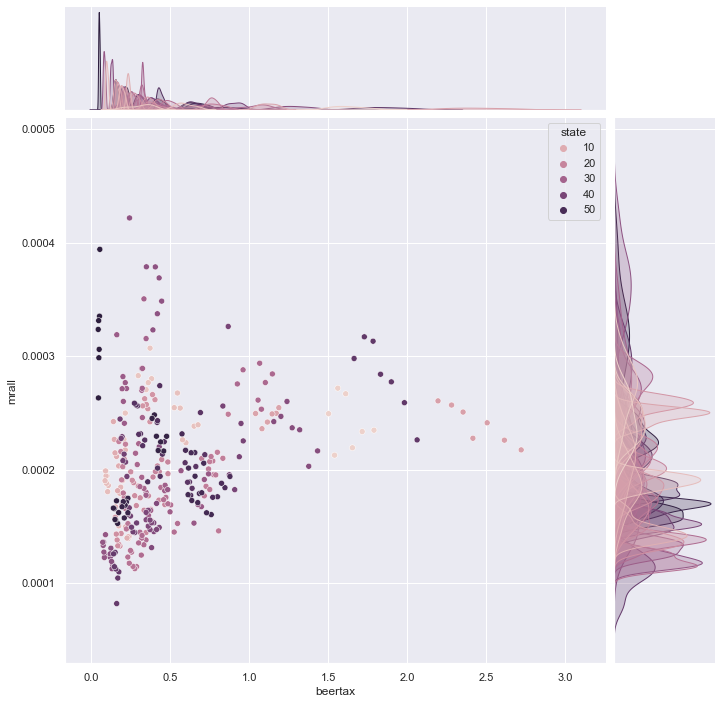

In [28]:
sns.jointplot(x="beertax", y="mrall", data=df,
           kind="scatter", hue="state", height=10, space=0.08)
plt.show()

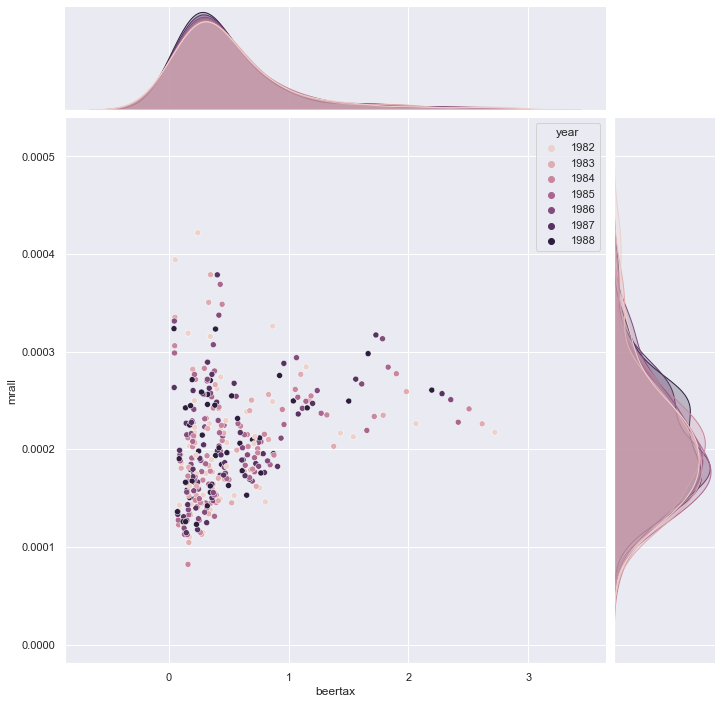

In [29]:
sns.jointplot(x="beertax", y="mrall", data=df,
           kind="scatter", hue="year", height=10, space=0.08)
plt.show()

There is not much heterogeneity from year on year, but there are large differences across states. Suspect that entity (state) effects will play substantial role, while accounting for time effects won't make much difference. 

In [30]:
# Fixed effects panel regression model
reg = PanelOLS.from_formula('mrall ~ 1+ beertax + EntityEffects',df)
res = reg.fit()
print(res)

                          PanelOLS Estimation Summary                           
Dep. Variable:                  mrall   R-squared:                        0.0407
Estimator:                   PanelOLS   R-squared (Between):             -0.7126
No. Observations:                 336   R-squared (Within):               0.0407
Date:                Sat, Feb 26 2022   R-squared (Overall):             -0.6380
Time:                        22:49:03   Log-likelihood                    3202.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      12.190
Entities:                          48   P-value                           0.0006
Avg Obs:                       7.0000   Distribution:                   F(1,287)
Min Obs:                       7.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             12.190
                            

However, the regression which includes state fixed effects, suggests that the positive coefficient in OLS regression is the result of omitted variable bias (the coefficient on the real beer tax is -0.655). The regression $R^2$ jumps from 0.090 lo 0.905 (see below) when fixed effects are included - evidently, the state fixed effects account for a large amount of the variation in the data.

In [31]:
# Inclussive R^2 from panel regression

#res.rsquared
#res.rsquared_between
res.rsquared_inclusive
#res.rsquared_overall
#res.rsquared_within

0.9050146809764925

In [32]:
# Fixed effects panel regression model
reg = PanelOLS.from_formula('mrall ~ 1+ beertax + EntityEffects + TimeEffects',df) 
res = reg.fit()
print(res)
res.rsquared_inclusive

                          PanelOLS Estimation Summary                           
Dep. Variable:                  mrall   R-squared:                        0.0361
Estimator:                   PanelOLS   R-squared (Between):             -0.6875
No. Observations:                 336   R-squared (Within):               0.0407
Date:                Sat, Feb 26 2022   R-squared (Overall):             -0.6154
Time:                        22:50:47   Log-likelihood                    3209.7
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      10.513
Entities:                          48   P-value                           0.0013
Avg Obs:                       7.0000   Distribution:                   F(1,281)
Min Obs:                       7.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             10.513
                            

0.9089266396679339

Now try without the `EntityEffects`. Recall, we saw data plot and assumed that the data distribution does not vary greatly from year on year. 

In [33]:
# Fixed effects panel regression model
reg = PanelOLS.from_formula('mrall ~ 1+ beertax +  TimeEffects',df)
res = reg.fit()
print(res)
res.rsquared_inclusive
#res.summary

                          PanelOLS Estimation Summary                           
Dep. Variable:                  mrall   R-squared:                        0.0945
Estimator:                   PanelOLS   R-squared (Between):              0.1100
No. Observations:                 336   R-squared (Within):              -0.0582
Date:                Sat, Feb 26 2022   R-squared (Overall):              0.0934
Time:                        22:50:58   Log-likelihood                    2824.6
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      34.246
Entities:                          48   P-value                           0.0000
Avg Obs:                       7.0000   Distribution:                   F(1,328)
Min Obs:                       7.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             34.246
                            

0.09864797268576897

In [34]:
# Random effects panel regression model
reg = RandomEffects.from_formula('mrall ~ 1+ beertax',df)
res = reg.fit()
print(res)
res.rsquared_inclusive # this is an attributione of panel data models. It will throw an error for non-panel models
#res.summary

                        RandomEffects Estimation Summary                        
Dep. Variable:                  mrall   R-squared:                        0.0005
Estimator:              RandomEffects   R-squared (Between):             -0.0324
No. Observations:                 336   R-squared (Within):               0.0062
Date:                Sat, Feb 26 2022   R-squared (Overall):             -0.0285
Time:                        22:51:20   Log-likelihood                    3169.0
Cov. Estimator:            Unadjusted                                           
                                        F-statistic:                      0.1755
Entities:                          48   P-value                           0.6756
Avg Obs:                       7.0000   Distribution:                   F(1,334)
Min Obs:                       7.0000                                           
Max Obs:                       7.0000   F-statistic (robust):             0.1755
                            

AttributeError: 'RandomEffectsResults' object has no attribute 'rsquared_inclusive'

# Further Readings
- Fixed Effects and Random Effects model applications can be found here: https://bashtage.github.io/linearmodels/doc/
- https://towardsdatascience.com/understanding-panel-data-regression-c24cd6c5151e